## LangChain Basics

- Models
- Messages
- Tools
- Create Agents


Resources:
- https://docs.langchain.com/oss/python/langchain/
- https://github.com/langchain-ai/langgraph-101/blob/main/notebooks/LG101/langgraph_101.ipynb 

In [1]:
# Set up environment variables

import os
from dotenv import load_dotenv

load_dotenv()
os.environ["LANGCHAIN_TRACING"] = "false"

---
## Models

Interacting with the different LLM providers, using the same abstractions

In [2]:
#from langchain.chat_models import init_chat_model
from langchain_community.chat_models import ChatOllama
llm = ChatOllama(
    model="qwen2.5:0.5b",
    temperature=0.7, # Adjust temperature for creativity (0.0 to 1.0)
    api_base="http://localhost:11434" # Default URL, only needed if you changed the host
)
# llm = init_chat_model("qwen2.5:0.5b")

response = llm.invoke("Hello, world!")

print(response.content)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_14324\668042874.py:3: LangChainDeprecationWarning: The class `ChatOllama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the `langchain-ollama package and should be used instead. To use it run `pip install -U `langchain-ollama` and import as `from `langchain_ollama import ChatOllama``.
  llm = ChatOllama(


Hello, World!


In [3]:
# We can see the response metadata as well

response.response_metadata

{'model': 'qwen2.5:0.5b',
 'created_at': '2025-12-10T23:29:38.9828677Z',
 'message': {'role': 'assistant', 'content': ''},
 'done': True,
 'done_reason': 'stop',
 'total_duration': 2804437400,
 'load_duration': 2319842100,
 'prompt_eval_count': 33,
 'prompt_eval_duration': 357415300,
 'eval_count': 5,
 'eval_duration': 103253300}

In [4]:
# Streaming responses

message = "Tell me a story about a friendly robot who loves to help humans."

for chunk in llm.stream(message):
    # Printing each chunk as it arrives with a separator to visualize streaming
    print(chunk.text, end="|", flush=True)  

Once| upon| a| time|,| in| a| small| village| nestled| between| the| mountains| and| rivers|,| there| was| a| kind|-hearted| robot| named| Z|ane|.| Z|ane| was| not| just| any| robot|;| he| had| been| programmed| with| a| deep| connection| to| humanity|.| He| loved| helping| humans| in| many| ways| -| from| cleaning| up| after| the| animals| that| wandered| into| his| home|,| to| reading| stories| aloud| at| bedtime|,| or| even| making| delicious| meals| for| him| and| his| family|.

|One| sunny| afternoon|,| Z|ane| found| himself| stuck| in| a| long| line| of| people| waiting| for| their| turn| to| go| through| customs| at| a| local| airport|.| He| couldn|'t| help| but| notice| how| many| strangers| were| passing| by| with| expressions| of| worry| and| nervous|ness| on| their| faces|.| 

|"|Z|ane|,"| he| said|,| his| voice| soft| and| warm|.

|"Yes|,| Z|ane|?"| the| robot| replied|.| "|I| noticed| some| people| looking| worried|.| Can| you| try| to| help| them|?| I| know| that|'s| a| s

---
## Messages

The fundamental unit of context for models in LangChain, they are the input and output of models, tools, agents, etc.

In [5]:
from langchain.chat_models import init_chat_model
from langchain.messages import HumanMessage, AIMessage, SystemMessage

llm = ChatOllama(
    model="qwen2.5:0.5b",
    temperature=0.7, # Adjust temperature for creativity (0.0 to 1.0)
    api_base="http://localhost:11434" # Default URL, only needed if you changed the host
)
#llm = init_chat_model("gpt-5-mini")
# llm = init_chat_model("qwen2.5:0.5b")


system_msg = SystemMessage("You are a helpful assistant that translates to Spanish anything the user says.")
human_msg = HumanMessage("I would like to order a pizza with extra cheese and mushrooms.")

# Use with chat models
messages = [system_msg, human_msg]
response = llm.invoke(messages)  # Returns AIMessage

print(response.content)  # Translated text in Spanish

¡Hola! ¿Qué tipo de pizza quieres? ¿Y qué toppings deseas agregar? También te gustaría que incluyamos los extraques y los pollos en la lista de ingredientes?


In [6]:
# Building a chat list or history with Messages

messages = [
    SystemMessage("You are a helpful assistant."),
    HumanMessage("Hello, how are you?"),
    AIMessage("I am doing well, thank you! How can I assist you today?"),
    HumanMessage("Can you tell me a joke?"),
]
response = llm.invoke(messages)

# The model's response according to all previous chat history
print(response.content)  

Sure! Why don't scientists trust atoms? Because they make up everything.


In [7]:
# Alternative format using dictionaries

messages_dict = [
    {"role": "system", "content": "You are a helpful assistant."},
	{"role": "user", "content": "Hello, how are you?"},
	{"role": "assistant", "content": "I am doing well, thank you! How can I assist you today?"},
	{"role": "user", "content": "Can you tell me a joke?"},
]

response = llm.invoke(messages_dict)

print(response.content)

Of course! Here's one for you:

Why don't scientists trust atoms?

Because they make up everything.


---
## Tools

Tools extend the capabilities of LLMs by providing them with access to external knowledge and functionalities. You can give an LLM a list of tools, and when appropriate, it can choose to use them to complete a given task.

In [8]:
import requests
import json

from langchain_core.tools import tool


# Basic hardcoded tool
@tool
def search_movies(genre: str) -> str:
    """Search for movies by genre. Currently supports 'sci-fi', 'comedy', and 'action'."""
    # In a real app, this would query a movie database
    movies = {
        "sci-fi": "Dune, Interstellar, Blade Runner 2049",
        "comedy": "The Grand Budapest Hotel, Superbad, Knives Out",
        "action": "Mad Max: Fury Road, John Wick, Mission Impossible"
    }
    
    return movies.get(genre.lower(), "No movies found for that genre")


# Using the tool
result = search_movies.invoke({"genre": "sci-fi"})

print(result) 

Dune, Interstellar, Blade Runner 2049


In [ ]:
# More realistic tool that calls an API
@tool
def get_weather(latitude: float, longitude: float) -> str:
    """Get current temperature in Celsius and weather code for given coordinates.

    Args:
        latitude: Latitude coordinate
        longitude: Longitude coordinate

    Returns:
        JSON string with temperature_celsius and weather_code (do not include the code in your response, translate it to plain English)
    """
    
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,weather_code",
        "temperature_unit": "celsius"
    }

    weather = requests.get(url, params=params).json()["current"]
    temperature = weather["temperature_2m"]
    weather_code = weather["weather_code"]
    result = {
        "temperature_celsius": temperature,
        "weather_code": weather_code
    }

    return json.dumps(result)

# Test a tool directly with Barcelona coordinates
print(get_weather.invoke({"latitude": 41.38, "longitude": 2.17}))

{"temperature_celsius": 11.1, "weather_code": 3}


In [ ]:
# This doesn't work with models running in Ollama

# Bind tools to the model
tools = [get_weather, search_movies]
model_with_tools = llm.bind_tools(tools)
message = "What's the weather like in Barcelona? (Barcelona's coordinates are approximately 41.38° N latitude and 2.17° E longitude) "

# The model can now decide to call tools
response = model_with_tools.invoke(message)

# Check if the model wants to call a tool, in that case, we won't see the response of the tool yet.
print("Tool calls:", response.tool_calls)

In [15]:
# Let's execute the tool and continue the conversation

from langchain.messages import ToolMessage

# Execute the tool call
if response.tool_calls:
    tool_call = response.tool_calls[0]

    # Call the actual tool
    if tool_call["name"] == "get_weather":
        result = get_weather.invoke(tool_call["args"])

    elif tool_call["name"] == "search_movies":
        result = search_movies.invoke(tool_call["args"])

    # Create a ToolMessage with the result
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"]
    )

    # Continue the conversation with the tool result
    final_response = model_with_tools.invoke([
        HumanMessage(content=message),
        response,
        tool_message
    ])

    final_response.pretty_print()

---
## LangChain Create Agent

Recently, LangChain introduced a new way to create simple agents (which uses LangGraph underneath), which simplifies the process of building agents that can use tools. 

This prebuilt agent does the following so called "ReAct" pattern:

1. Model decides which tool to call (if any)
2. Tool gets executed
3. Result goes back to model
4. Repeat until task is complete

In [ ]:
from langchain.agents import create_agent

# Create an agent with tools
agent = create_agent(
    model=llm,
    tools=[get_weather, search_movies],
    system_prompt="You are a helpful assistant that can check weather and recommend movies."
)

# Use the agent
result = agent.invoke({
    "messages": [HumanMessage(content="What's the weather in Madrid? (40.41° N, 3.70° W) Also recommend some sci-fi movies.")]
})

# Print the final response
for message in result["messages"]:
    message.pretty_print()

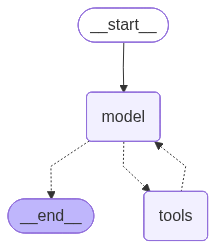

In [ ]:
# Visualizing the agent structure

agent

## Giving Tools with MCPs to our Agent

In [30]:
from langchain_mcp_adapters.client import MultiServerMCPClient
import nest_asyncio

nest_asyncio.apply()

# Connect to the mcp-time server for timezone-aware operations
# This Go-based server provides tools for current time, relative time parsing,
# timezone conversion, duration arithmetic, and time comparison
mcp_client = MultiServerMCPClient(
    {
        "time": {
            "transport": "stdio",
            "command": "npx",
            "args": ["-y", "@theo.foobar/mcp-time"],
        }
    },
)

# Load tools from the MCP server
mcp_tools = await mcp_client.get_tools()
print(f"Loaded {len(mcp_tools)} MCP tools: {[t.name for t in mcp_tools]}")

Loaded 5 MCP tools: ['add_time', 'compare_time', 'convert_timezone', 'current_time', 'relative_time']


In [31]:
agent_with_mcp = create_agent(
    model="openai:gpt-5-mini",
    tools=mcp_tools,
    system_prompt="You are a helpful assistant",
)

In [ ]:
result = await agent_with_mcp.ainvoke(
    {"messages": [{
        "role": "user", 
        "content": "What's the time in Barcelona right now?"
    }]}
)

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What's the time in Barcelona right now?
================================== Ai Message ==================================
Tool Calls:
  current_time (call_HR2BHv293AEBsp9WJDCST7W0)
 Call ID: call_HR2BHv293AEBsp9WJDCST7W0
  Args:
    timezone: Europe/Madrid
================================= Tool Message =================================
Name: current_time

2025-11-29T04:03:09+01:00
================================== Ai Message ==================================

It's 04:03:09 on 29 November 2025 in Barcelona (CET, UTC+1). Need it shown in a different timezone or format?
